# Centre of a satellite orbit

This code seeks to determine the centre of a satellite orbit
## Background
Satellite state vectors define the position and velocity vectors of a satellite, usually in an Earth-Centred Earth-Fixed (ECEF) coordinate system. Examination of state vectors (for instance those that accompany SAR data, or data that is captured and recorded for Sentinel-1 at https://https://qc.sentinel1.eo.esa.int/aux_poeorb/. Upon examination of the state vector position data (perhaps by looking at 5 sequential state vectors), one finds that the magnitude of the position vector changes showing that with reference the centre of the Earth. The orbit is not locally circular.

SAR processing algorithms that are derived under the assumption of a locally circular orbit would thus not make sense because the effective velocity term used in the development of SAR processing algorithms would not have a sensible basis.

In [1]:
import numpy as np
import numpy.matlib as npmat
from scipy.linalg import expm
from scipy.optimize import minimize
import sys
import datetime
sys.path.append('/home/ishuwa_tinda/local/src/Python/radar')
import matplotlib.pyplot as plt
from measurement.measurement import state_vector_ESAEOD
from measurement.measurement import state_vector
from measurement.arclength import slow
%matplotlib notebook

## Create a state vector object

In [2]:
orbit_file = "/home/ishuwa/local/src/Python/sarsim/radar/orbit/S1B_OPER_AUX_POEORB_OPOD_20180825T110641_V20180804T225942_20180806T005942.EOF"
sv = state_vector_ESAEOD()
start_date = datetime.datetime(2018,8,5,6,20,22)
end_date = start_date + datetime.timedelta(seconds=60)
#svecs = sv.readStateVectors(orbit_file, start_date, end_date)
svecs = sv.readStateVectors(orbit_file)

## Extract state vector data
The state vector contains both position and velocity components. We're only interested, at the moment, in the position elements

In [3]:
#%% Compute state vectors
#s_idx = int(len(sv.measurementTime)/2)
s_idx = 6133 # Zambia
s_idx = 4591
s_time = sv.measurementTime[s_idx]
s_vect = sv.measurementData[s_idx]

# Create a new state vector object to propagate
myrd = state_vector()
myrd.add(s_time, s_vect)

# def satellitePositionsArclength(myrd, prf = 10.0, nSamples=80):
nSamples = 80
prf = 2

deltaT = 1.0/prf

xState = myrd.expandedState(myrd.measurementData[0], 0.0)
# reference_time = myrd.measurementTime[0]
reference_time = np.datetime64(datetime.datetime.strftime(myrd.measurementTime[0], "%Y-%m-%dT%H:%M:%S.%f"))

np_prf = np.timedelta64(int(np.round(1e9/prf)),'ns')
svTime = myrd.measurementTime[0]# + np_prf*rnSamples/2.0
print("Reference time:")
print(reference_time)
print(xState)

Reference time:
2018-08-05T11:44:52.000000
[[ 1.05362658e+06 -4.82818919e+06  5.05502146e+06]
 [-7.23181280e+02 -5.54572716e+03 -5.13302173e+03]
 [-1.98946192e+00  5.51598459e+00 -5.70661938e+00]
 [ 1.61100191e-03  6.52045391e-03  5.77806941e-03]]


In [4]:
# Compute the geographic coordinates
llh = sv.xyz2polar(sv.measurementData[s_idx][0:3])
print("lat,lon,H (%0.4f, %0.4f, %0.1f)" % llh)

lat,lon,H (45.8221, -77.6897, 702105.3)


In [5]:
myrd.measurementTime

[datetime.datetime(2018, 8, 5, 11, 44, 52)]

In [6]:
# Compute the integration times
half_time = deltaT*nSamples/2
integration_times = np.arange(-half_time, half_time+deltaT, deltaT)
numerical_sv = myrd.estimateTimeRange(myrd.measurementTime, integrationTimes=integration_times)

In [7]:
npos = numerical_sv[:,0:3].T
nvel = numerical_sv[:,3:6].T

In [8]:
# Create a slow time object
C = slow([reference_time])
C.t = integration_times
dummy = C.diffG(xState)

kappa: 1.419888663e-07 tau: 1.282419356e-08 dkappa: -5.909029918e-17


In [9]:
# Convert time to arclength in the slow-time object
C.t2s()

In [10]:
mysv_secs = [(st - sv.measurementTime[s_idx]).total_seconds() for st in sv.measurementTime]
mysv_secs = np.array([(idx,st) for idx,st in enumerate(mysv_secs) if st>=-half_time and st <=half_time])
print(mysv_secs)
s_idxs = [np.argmin(np.abs(integration_times - st[1])) for st in mysv_secs]
print(s_idxs)
subset_integrated = npos[:,s_idxs]
subset_times = np.array([k[1] for k in mysv_secs])
from_file = np.array([sv.measurementData[int(k[0])][0:3] for k in mysv_secs]).T
from_file - subset_integrated

[[4589.  -20.]
 [4590.  -10.]
 [4591.    0.]
 [4592.   10.]
 [4593.   20.]]
[0, 20, 40, 60, 80]


array([[-3.51584051e-04, -1.10493507e-04,  0.00000000e+00,
        -1.85441459e-05, -1.67963910e-04],
       [-2.88395211e-04, -7.71582127e-05,  0.00000000e+00,
        -7.71451741e-05, -3.29224393e-04],
       [ 2.00694427e-04,  6.19525090e-05,  0.00000000e+00,
         1.17756426e-05,  9.19057056e-05]])

<IPython.core.display.Javascript object>


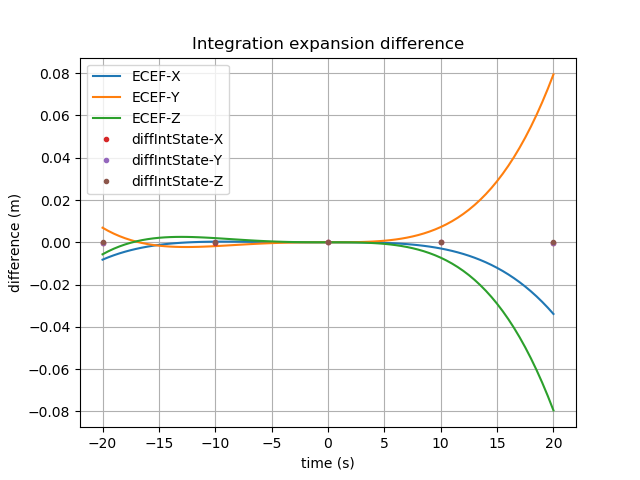

In [11]:
# Plot the differences
plt.figure()
plt.plot(integration_times, (C.c - npos).T, subset_times, (from_file-subset_integrated).T, '.')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('difference (m)')
plt.legend(['ECEF-X','ECEF-Y','ECEF-Z', 'diffIntState-X', 'diffIntState-Y', 'diffIntState-Z'])
plt.title('Integration expansion difference')
plt.show()

In [12]:
satRhat = npos/np.outer(np.ones((3,)), np.linalg.norm(npos, axis=0))
satVhat = nvel/np.outer(np.ones((3,)), np.linalg.norm(nvel, axis=0))
satBhat = np.cross(satRhat, satVhat, axis=0)

In [13]:
# Calculate the 30 depression angle curve
lookAngle = 45/180*np.pi
satLook = np.sin(lookAngle)*satBhat + np.cos(lookAngle)*satRhat

<IPython.core.display.Javascript object>


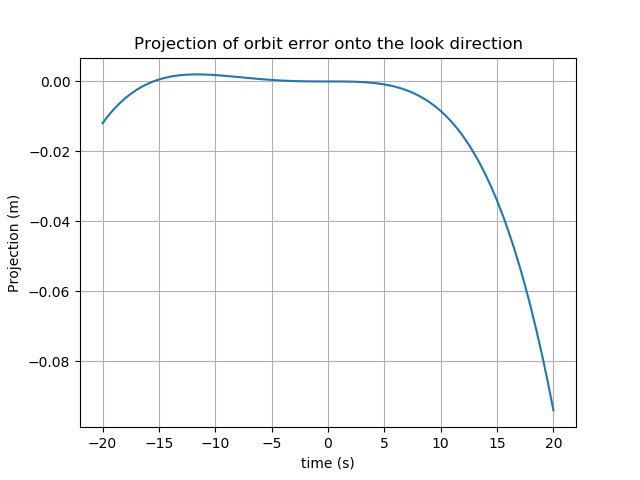

In [14]:
# Plot the projection of the difference vector in the 30 degree direction
projectionLook = np.sum((C.c-npos)*satLook, axis=0)
plt.figure()
plt.plot(integration_times, projectionLook)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Projection (m)')
plt.title('Projection of orbit error onto the look direction')
plt.show()

In [15]:
np.linalg.norm(satBhat[:,0])

0.9999992600009282

In [16]:
from ipyleaflet import Map, Marker, Popup

In [17]:
center = (llh[0], llh[1])

m = Map(center=(0,0), zoom=1)

marker = Marker(location=center, draggable=True)
m.add_layer(marker);

display(m)

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…